In [1]:
using Revise

In [2]:
using MeshCatMechanisms
using MeshCat
using RigidBodyDynamics
using Flux
using ProgressMeter
using Blink
using MLDataPattern
using JLD2
using Plots; gr()
using LCPSim
using LearningMPC
using LearningMPC.Models

INFO: Recompiling stale cache file /home/rdeits/locomotion/explorations/learning-mpc-2/packages/lib/v0.6/LearningMPC.ji for module LearningMPC.


In [3]:
robot = BoxAtlas()
mvis = MechanismVisualizer(robot)
open(mvis, Window())

Blink.AtomShell.Window(1, Blink.AtomShell.Electron(Process(`/home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/deps/atom/electron /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/src/AtomShell/main.js port 6323`, ProcessRunning), TCPSocket(RawFD(48) active, 0 bytes waiting), Dict{String,Any}(Pair{String,Any}("callback", Blink.#3))), Blink.Page(1, WebSockets.WebSocket{TCPSocket}(TCPSocket(RawFD(56) active, 0 bytes waiting), true, CONNECTED::WebSockets.ReadyState = 1), Dict{String,Any}(Pair{String,Any}("webio", WebIO.#111),Pair{String,Any}("callback", Blink.#3)), Future(1, 1, 1, Nullable{Any}(true))))

In [4]:
params = MPCParams(robot)
lqrsol = LQRSolution(robot, params, false)
net, loss = LearningMPC.interval_net([22, 128, 128, 1])
optimizer = Flux.ADAM(Flux.params(net))

net_cost = LearningMPC.LearnedCost(lqrsol, net)

net_mpc_params = MPCParams(robot)
net_mpc_params.horizon = 1
net_mpc_controller = MPCController(robot, net_mpc_params, net_cost, [lqrsol]);

full_mpc_controller = MPCController(robot, params, lqrsol, [lqrsol, net_mpc_controller]);

lqr_mpc_controller = MPCController(robot, (p = MPCParams(robot); p.horizon=1; p), lqrsol, [lqrsol])

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


(::MPCController) (generic function with 1 method)

In [5]:
sample_sink = LearningMPC.MPCSampleSink{Float64}(true)
playback_sink = LearningMPC.PlaybackSink{Float64}(mvis)

full_mpc_controller.callback = LearningMPC.call_each(
    sample_sink,
    playback_sink,
)

live_viewer = LearningMPC.live_viewer(mvis)

dagger_controller = LearningMPC.call_each(
    LearningMPC.dagger_controller(
        full_mpc_controller,
        net_mpc_controller,
        0.2),
    live_viewer
    )

dataset = LearningMPC.Dataset(lqrsol)

x_init = nominal_state(robot)

function collect_into!(data::Vector{<:LearningMPC.Sample}, σv=1.0)
    empty!(sample_sink)
    LearningMPC.randomize!(x0, x_init, 0.0, σv)
    results = LCPSim.simulate(x0, 
        dagger_controller,
        robot.environment, params.Δt, 100, 
        params.lcp_solver;
        termination=x -> configuration(x)[3] > π/4 || configuration(x)[3] < -π/4);
    append!(data, sample_sink.samples)
end

x0 = MechanismState{Float64}(robot.mechanism)

features(s::LearningMPC.Sample) = (s.state, s.mip.objective_bound, s.mip.objective_value)

features (generic function with 1 method)

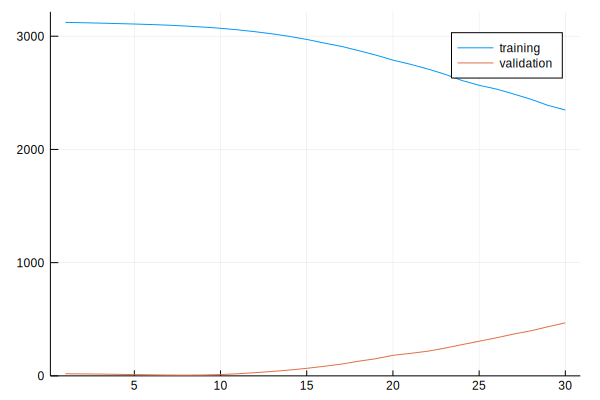

  2.742714 seconds (1.57 M allocations: 101.074 MiB, 2.17% gc time)


Progress:   1%|                                         |  ETA: 16:50:42

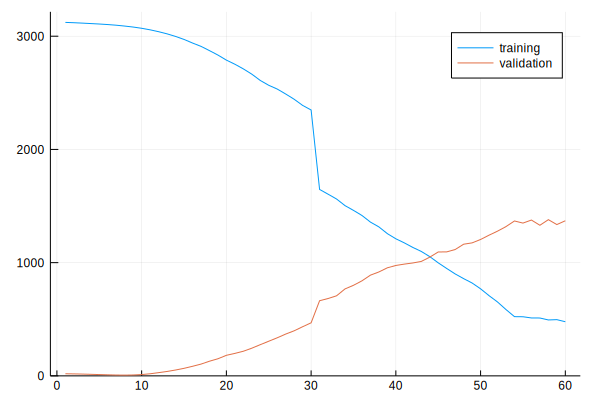

  0.794060 seconds (326.28 k allocations: 46.618 MiB, 2.29% gc time)


Progress:   2%|█                                        |  ETA: 10:49:26

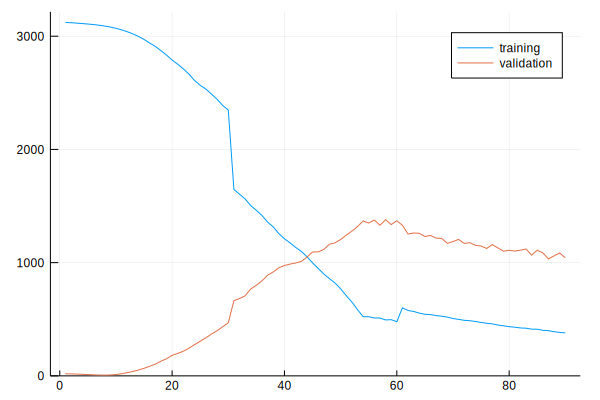

  0.934618 seconds (378.03 k allocations: 53.752 MiB, 3.06% gc time)


Progress:   3%|█                                        |  ETA: 7:41:37

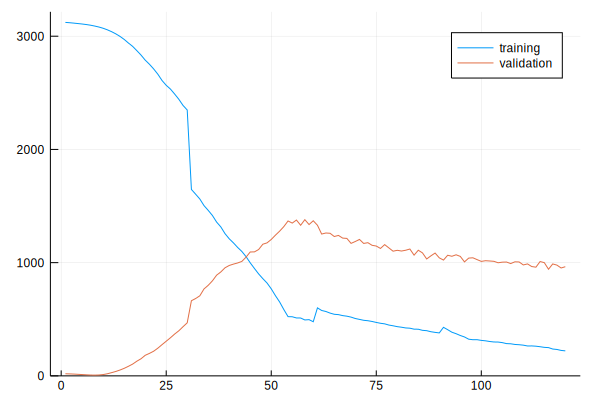

  1.024339 seconds (410.64 k allocations: 58.498 MiB, 2.76% gc time)


Progress:   4%|██                                       |  ETA: 6:20:14

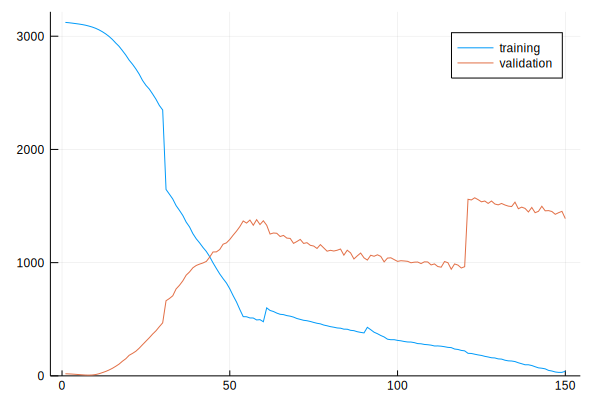

  1.149441 seconds (437.49 k allocations: 62.360 MiB, 2.36% gc time)


Progress:   5%|██                                       |  ETA: 5:35:03

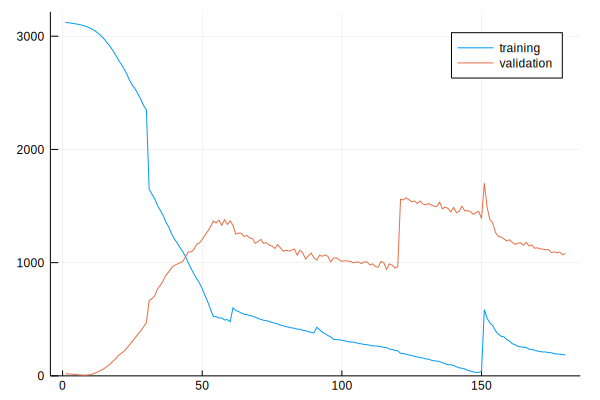

  2.477585 seconds (943.56 k allocations: 132.778 MiB, 2.13% gc time)


Progress:   6%|██                                       |  ETA: 7:30:13

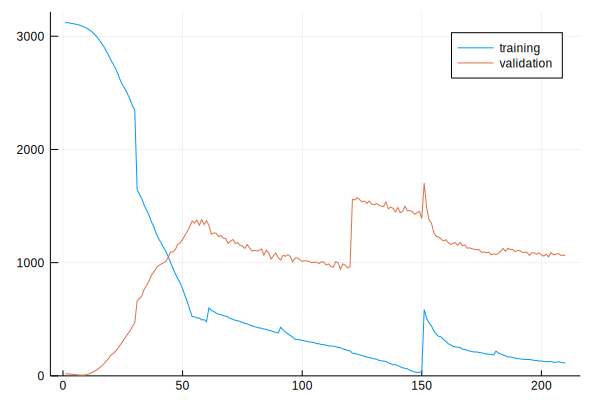

  2.378144 seconds (979.98 k allocations: 137.832 MiB, 2.28% gc time)


Progress:   7%|███                                      |  ETA: 6:43:51

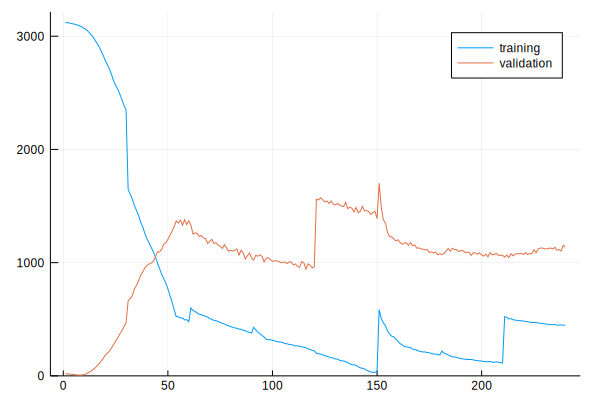

  2.707600 seconds (1.12 M allocations: 156.565 MiB, 2.49% gc time)


Progress:   8%|███                                      |  ETA: 6:16:27

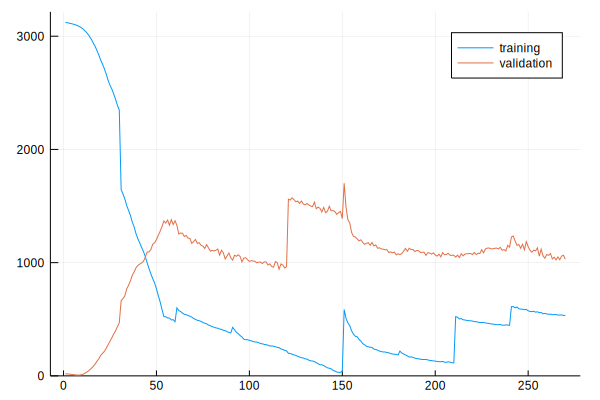

  3.842051 seconds (1.32 M allocations: 185.640 MiB, 1.92% gc time)


Progress:   9%|████                                     |  ETA: 7:24:54

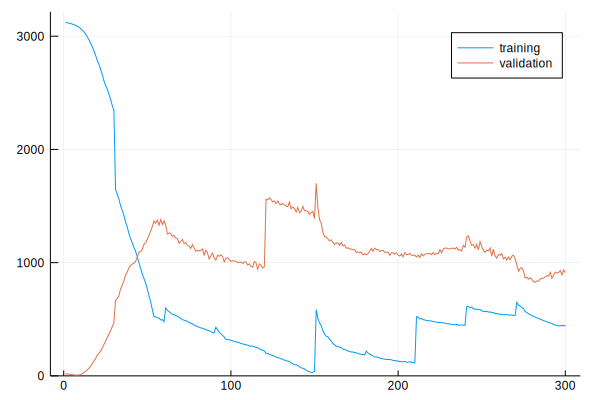

  4.744653 seconds (1.68 M allocations: 236.735 MiB, 2.07% gc time)


Progress:  10%|████                                     |  ETA: 7:41:01

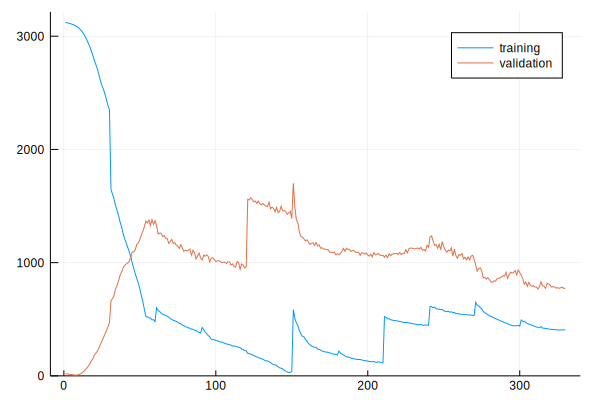

  5.076115 seconds (1.81 M allocations: 254.862 MiB, 2.13% gc time)


Progress:  11%|█████                                    |  ETA: 7:27:40

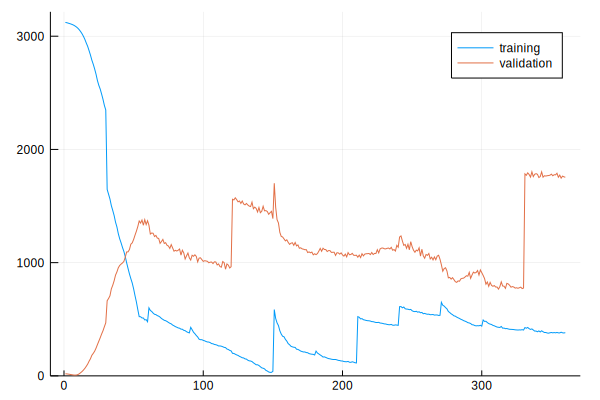

  7.892725 seconds (1.91 M allocations: 267.937 MiB, 1.35% gc time)


Progress:  12%|█████                                    |  ETA: 7:02:57

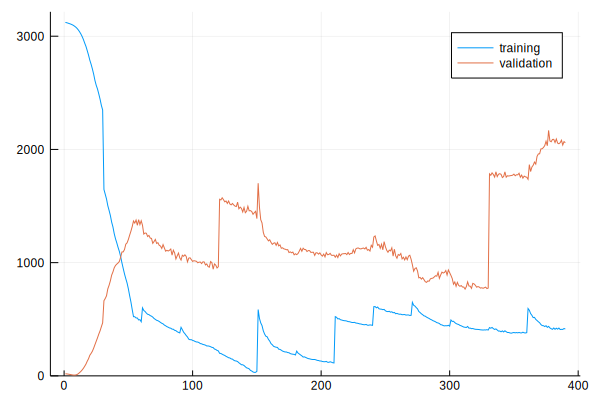

  6.216971 seconds (2.01 M allocations: 282.203 MiB, 2.43% gc time)


Progress:  13%|█████                                    |  ETA: 6:38:43

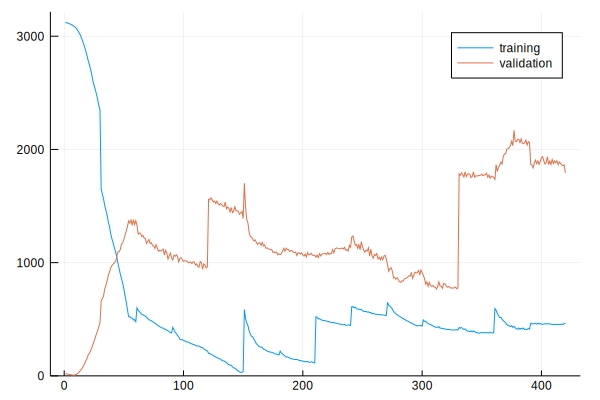

  7.822208 seconds (2.12 M allocations: 299.109 MiB, 1.61% gc time)


Progress:  14%|██████                                   |  ETA: 6:38:49

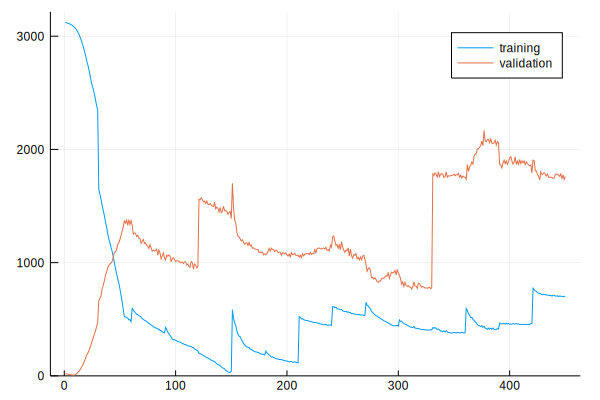

 13.906131 seconds (2.38 M allocations: 334.779 MiB, 1.11% gc time)


Progress:  15%|██████                                   |  ETA: 6:36:44

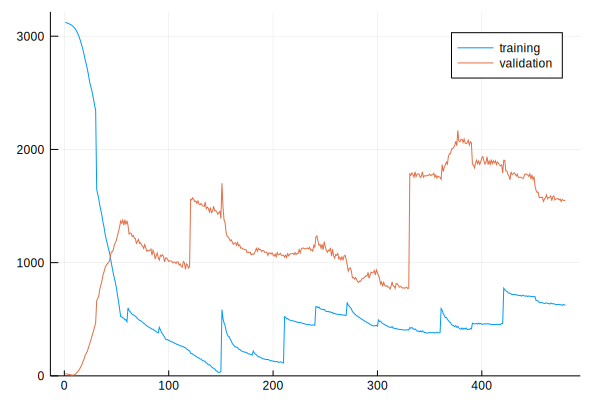

 13.655117 seconds (2.62 M allocations: 368.644 MiB, 1.36% gc time)


Progress:  16%|███████                                  |  ETA: 6:39:39

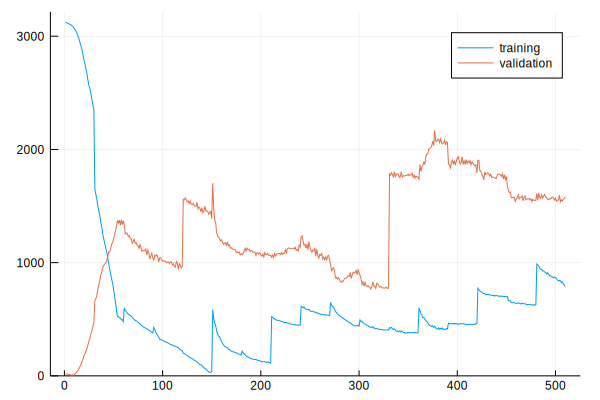

 14.233346 seconds (2.76 M allocations: 387.073 MiB, 1.14% gc time)


Progress:  17%|███████                                  |  ETA: 6:22:37

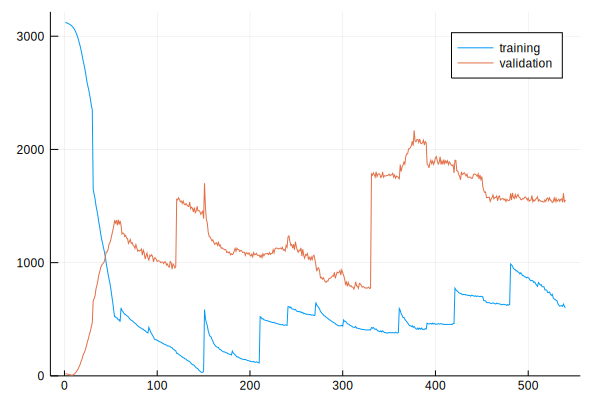

 14.912776 seconds (2.78 M allocations: 390.061 MiB, 1.12% gc time)


Progress:  18%|███████                                  |  ETA: 6:02:13

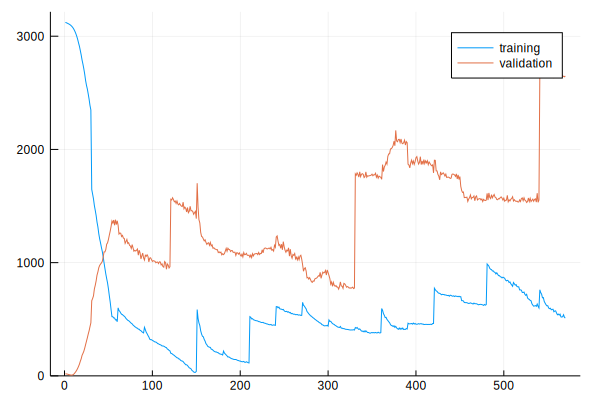

 15.901428 seconds (3.05 M allocations: 427.794 MiB, 1.13% gc time)


Progress:  19%|████████                                 |  ETA: 6:05:30

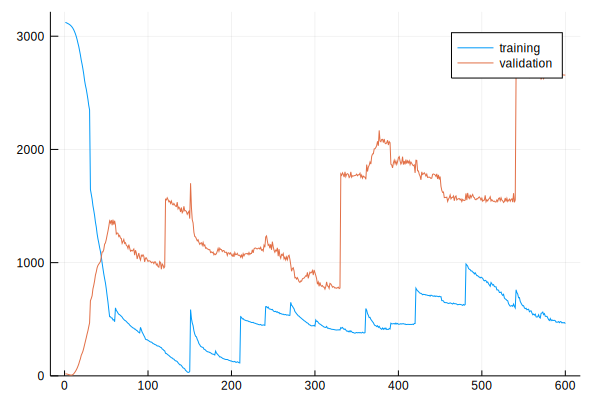

 17.975617 seconds (3.08 M allocations: 431.652 MiB, 1.30% gc time)


Progress:  20%|████████                                 |  ETA: 5:48:44

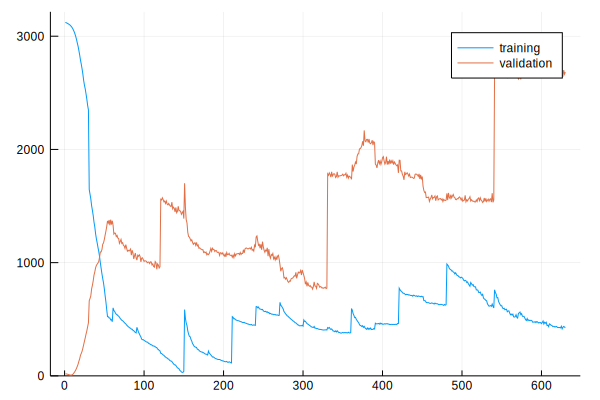

 15.980405 seconds (3.14 M allocations: 439.978 MiB, 1.13% gc time)


Progress:  21%|█████████                                |  ETA: 5:36:37

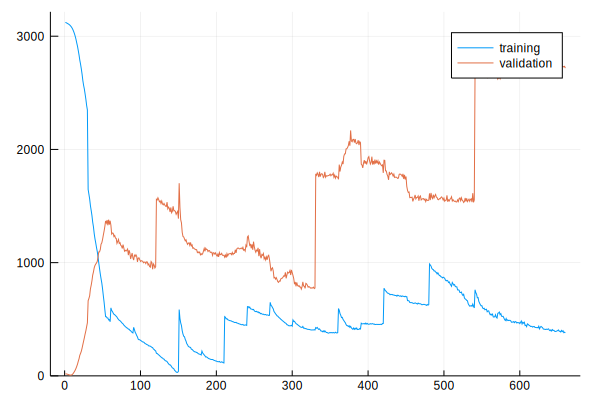

 17.222807 seconds (3.18 M allocations: 445.918 MiB, 1.12% gc time)


Progress:  22%|█████████                                |  ETA: 5:27:36

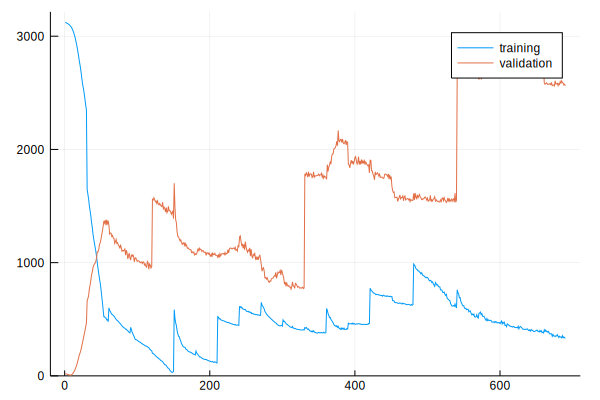

 15.773252 seconds (3.36 M allocations: 469.986 MiB, 1.33% gc time)


Progress:  23%|█████████                                |  ETA: 5:24:19

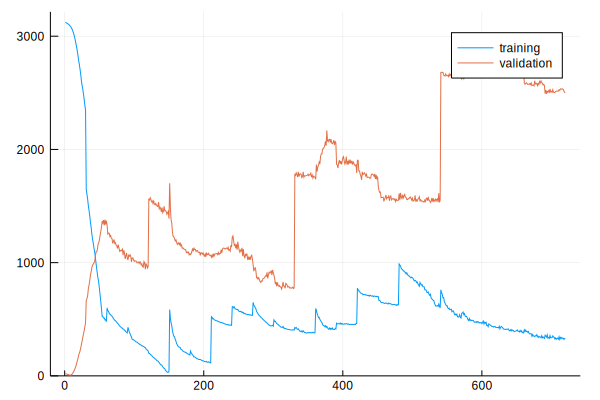

 22.281134 seconds (3.45 M allocations: 482.170 MiB, 1.10% gc time)


Progress:  24%|██████████                               |  ETA: 5:19:53

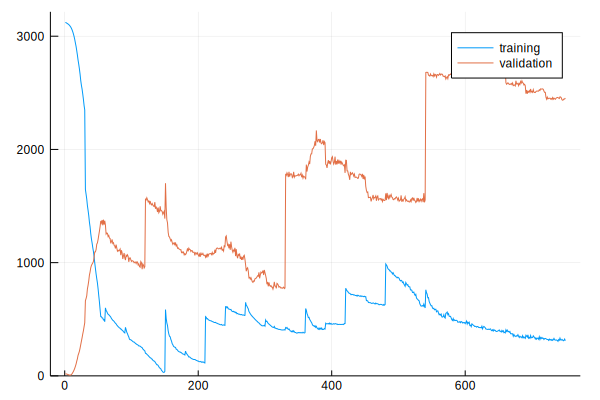

 20.051941 seconds (3.50 M allocations: 490.776 MiB, 1.25% gc time)


Progress:  25%|██████████                               |  ETA: 5:14:34

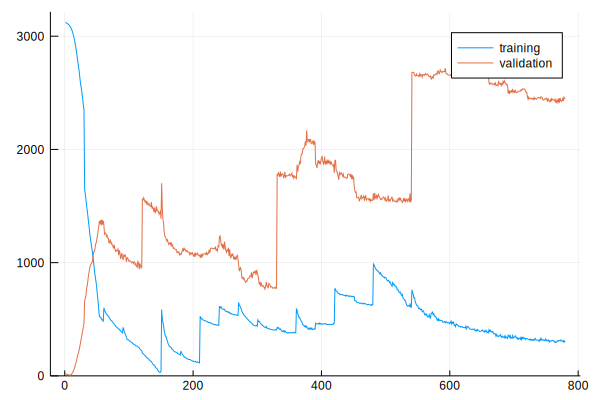

 17.440242 seconds (3.59 M allocations: 502.660 MiB, 1.27% gc time)


Progress:  26%|███████████                              |  ETA: 5:07:59

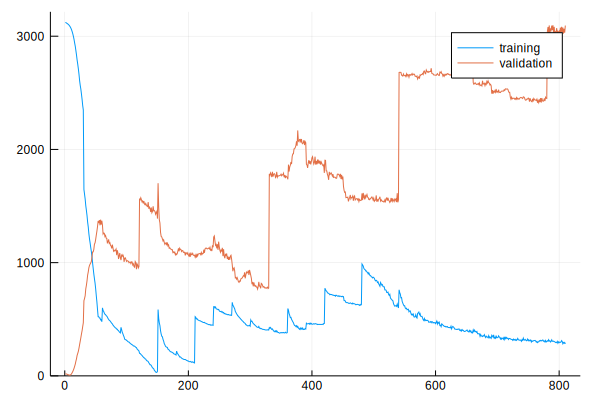

 20.708125 seconds (3.73 M allocations: 521.673 MiB, 1.02% gc time)


Progress:  27%|███████████                              |  ETA: 5:02:26

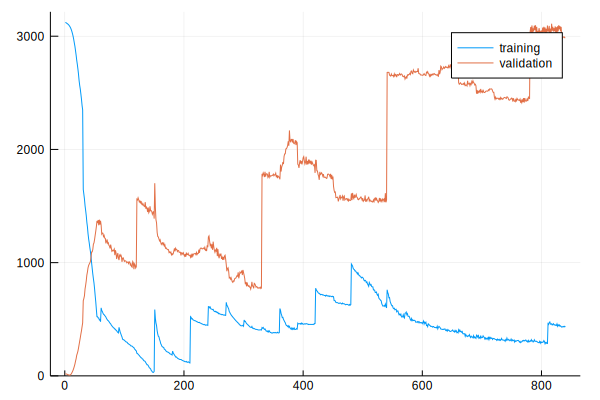

 19.472055 seconds (3.85 M allocations: 538.908 MiB, 1.10% gc time)


Progress:  28%|███████████                              |  ETA: 4:55:17

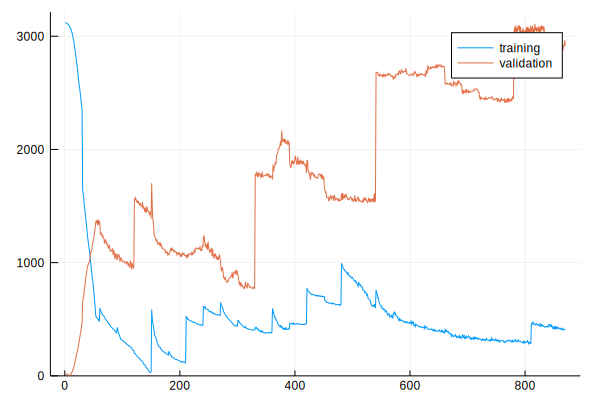

 23.386510 seconds (3.91 M allocations: 547.519 MiB, 1.05% gc time)


Progress:  29%|████████████                             |  ETA: 4:47:54

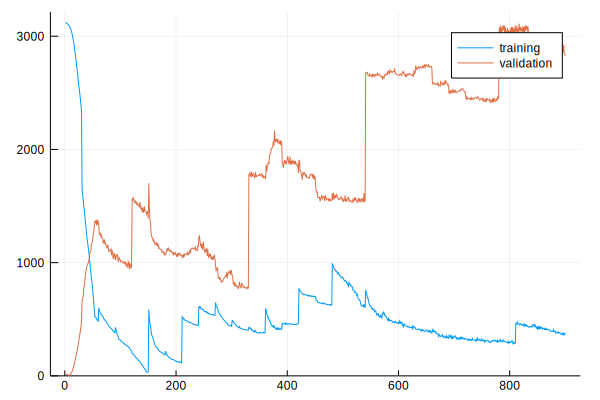

 24.914606 seconds (4.03 M allocations: 564.754 MiB, 1.06% gc time)


Progress:  30%|████████████                             |  ETA: 4:42:44

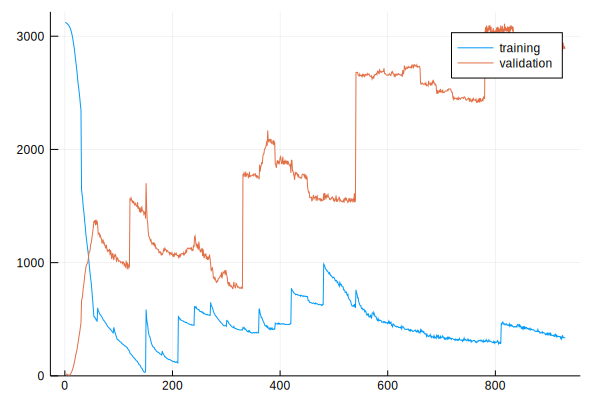

 21.741595 seconds (4.05 M allocations: 567.724 MiB, 1.15% gc time)


Progress:  31%|█████████████                            |  ETA: 4:33:06

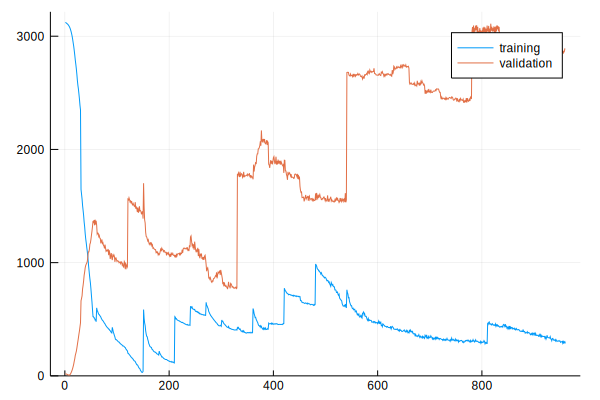

 25.840305 seconds (4.12 M allocations: 577.523 MiB, 1.00% gc time)


Progress:  32%|█████████████                            |  ETA: 4:27:43

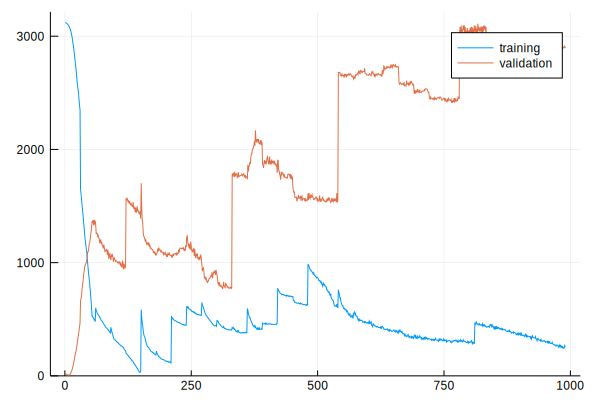

 26.118187 seconds (4.21 M allocations: 589.987 MiB, 1.08% gc time)


Progress:  33%|██████████████                           |  ETA: 4:29:02

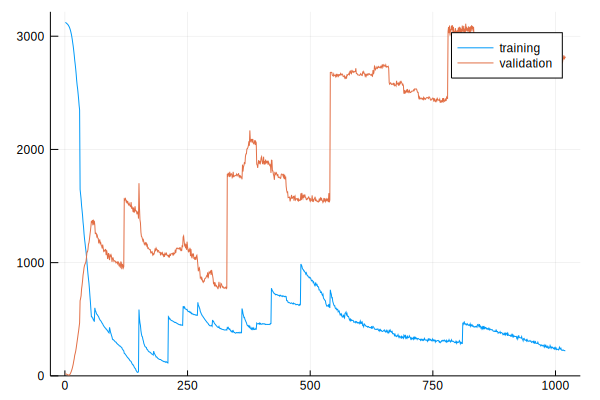

 24.700406 seconds (4.40 M allocations: 616.723 MiB, 1.16% gc time)


Progress:  34%|██████████████                           |  ETA: 4:27:07

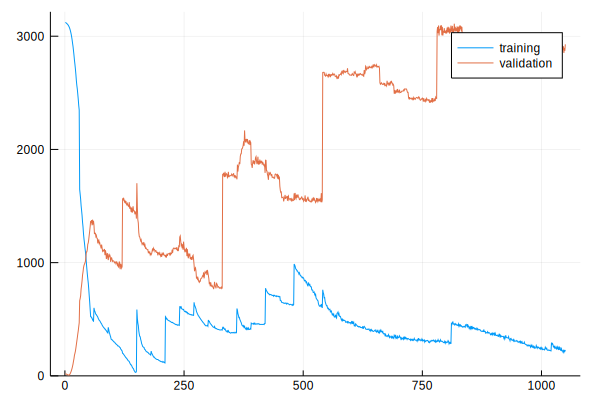

 31.073756 seconds (4.67 M allocations: 653.612 MiB, 1.04% gc time)


Progress:  35%|██████████████                           |  ETA: 4:29:41

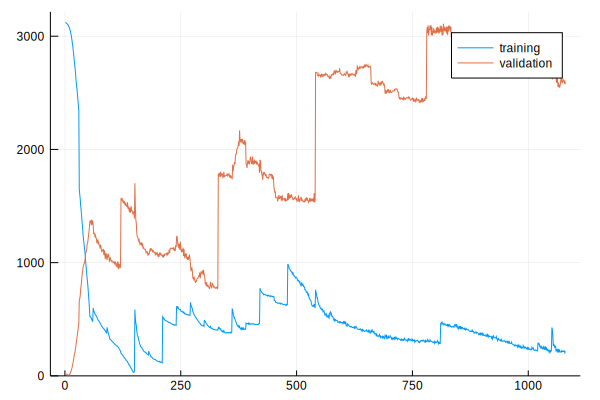

 31.941738 seconds (4.99 M allocations: 699.327 MiB, 1.02% gc time)


Progress:  36%|███████████████                          |  ETA: 4:30:59

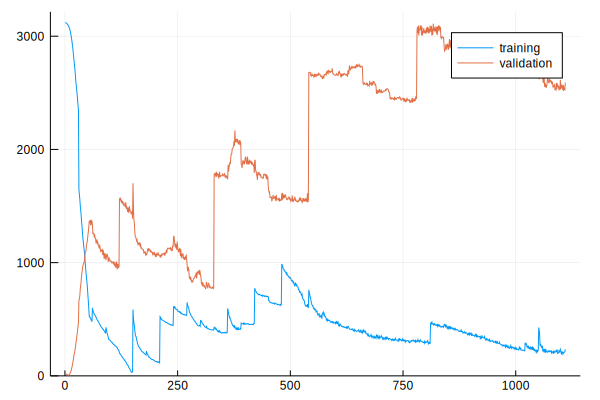

 29.416064 seconds (5.08 M allocations: 711.511 MiB, 1.02% gc time)


Progress:  37%|███████████████                          |  ETA: 4:23:31

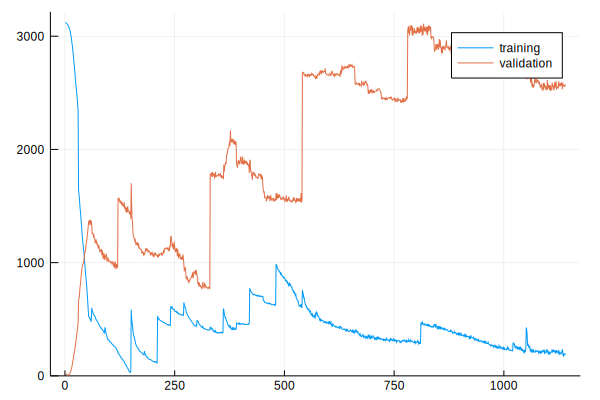

 31.029591 seconds (5.21 M allocations: 729.053 MiB, 1.10% gc time)


Progress:  38%|████████████████                         |  ETA: 4:17:31

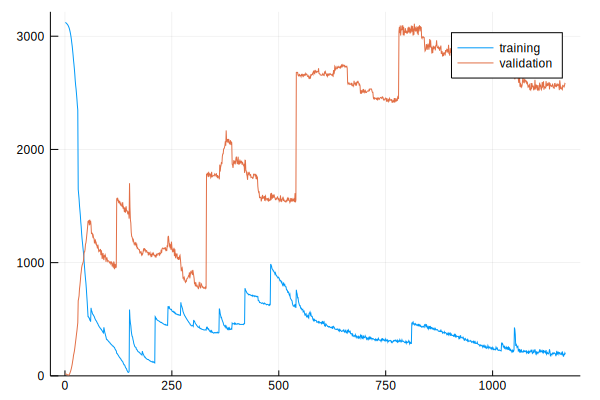

 28.522341 seconds (5.28 M allocations: 738.269 MiB, 1.32% gc time)


Progress:  39%|████████████████                         |  ETA: 4:10:58

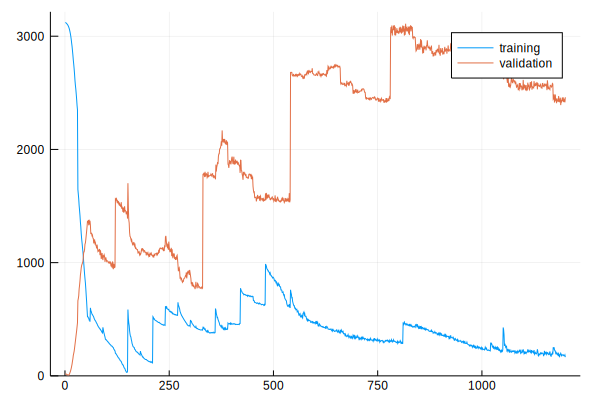

 34.352796 seconds (5.59 M allocations: 781.350 MiB, 1.01% gc time)


Progress:  40%|████████████████                         |  ETA: 4:11:17

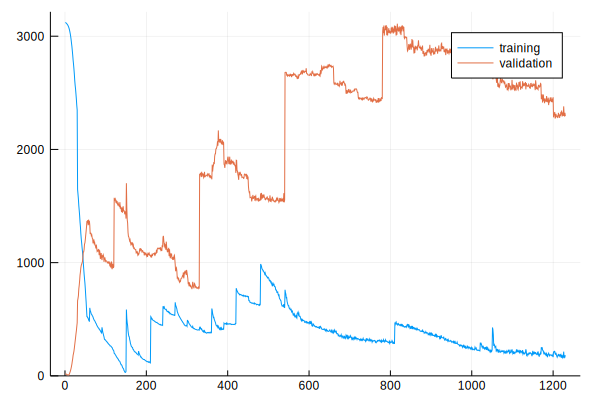

 32.948980 seconds (5.89 M allocations: 823.822 MiB, 1.08% gc time)


Progress:  41%|█████████████████                        |  ETA: 4:12:13

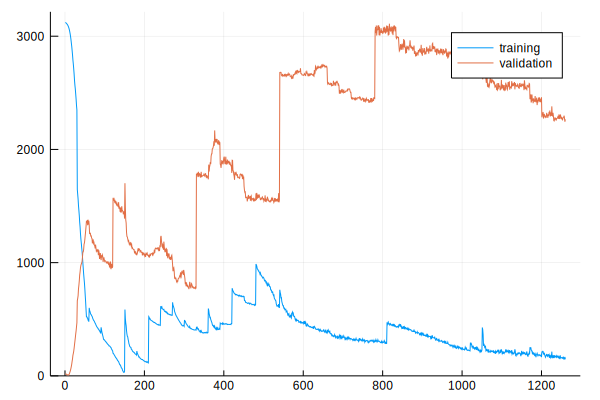

 36.933767 seconds (6.00 M allocations: 839.865 MiB, 1.02% gc time)


Progress:  42%|█████████████████                        |  ETA: 4:07:30

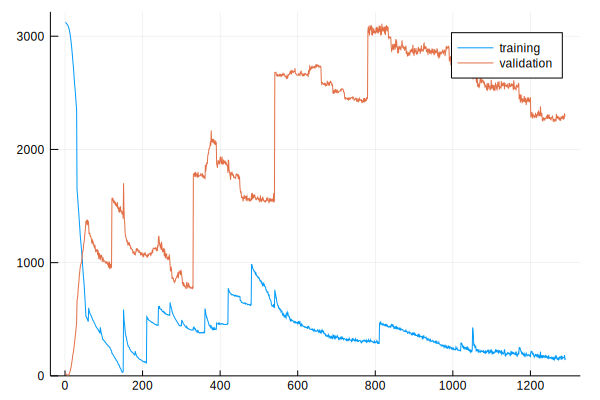

 33.584211 seconds (6.07 M allocations: 849.081 MiB, 1.49% gc time)


Progress:  43%|██████████████████                       |  ETA: 4:01:49

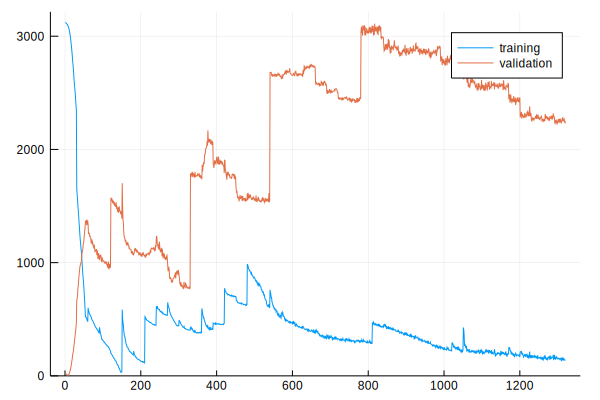

 33.252466 seconds (6.26 M allocations: 875.533 MiB, 1.15% gc time)


Progress:  44%|██████████████████                       |  ETA: 3:57:24

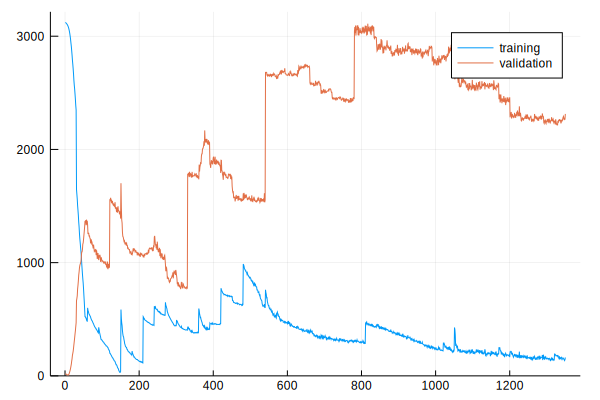

 39.070393 seconds (6.64 M allocations: 926.381 MiB, 1.97% gc time)


Progress:  45%|██████████████████                       |  ETA: 3:56:41

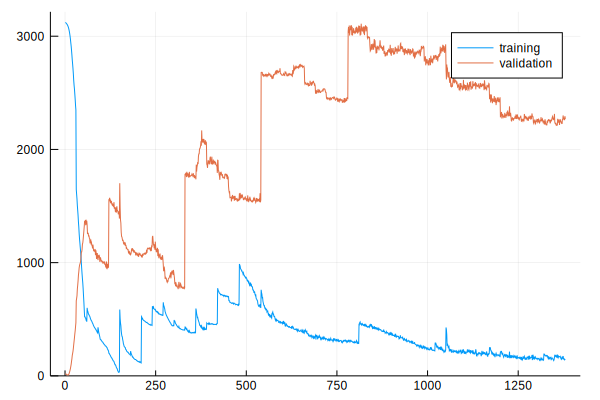

 41.831133 seconds (6.82 M allocations: 951.947 MiB, 0.98% gc time)


Progress:  46%|███████████████████                      |  ETA: 3:52:24

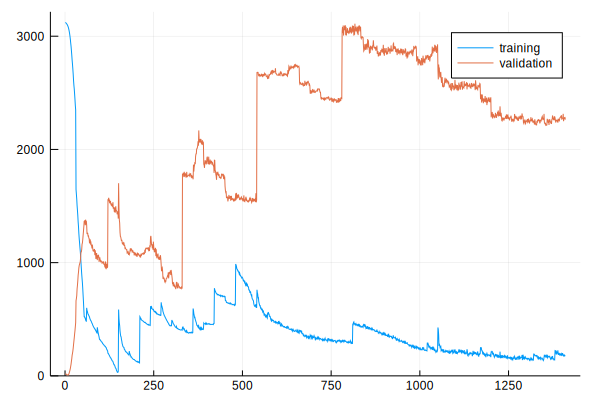

 37.943790 seconds (6.99 M allocations: 975.429 MiB, 1.16% gc time)


Progress:  47%|███████████████████                      |  ETA: 3:49:03

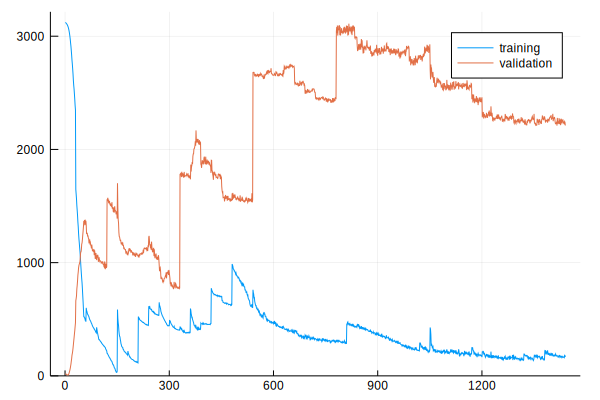

 31.934975 seconds (7.17 M allocations: 1000.383 MiB, 1.17% gc time)


Progress:  48%|████████████████████                     |  ETA: 3:44:54

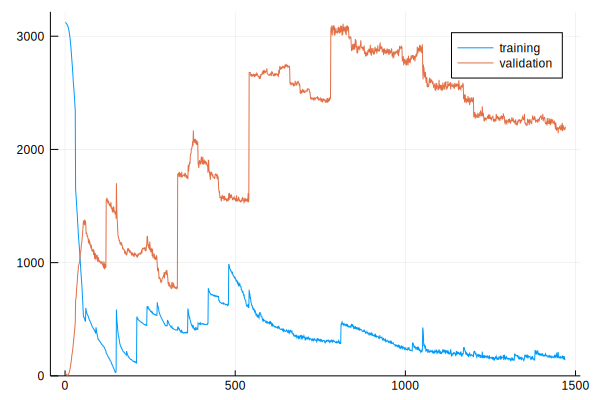

 44.426190 seconds (7.28 M allocations: 1016.707 MiB, 1.05% gc time)


Progress:  49%|████████████████████                     |  ETA: 3:40:35

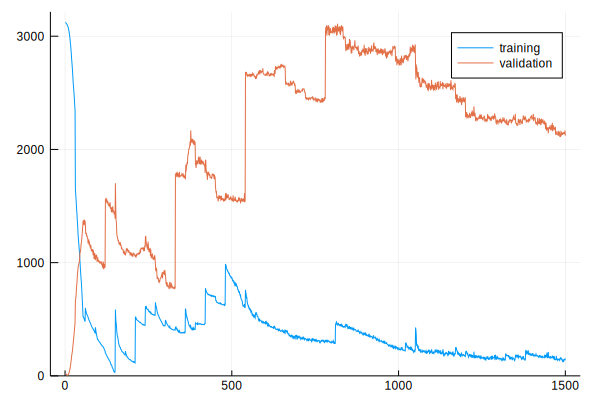

 45.670528 seconds (7.37 M allocations: 1.005 GiB, 1.12% gc time)


Progress:  50%|████████████████████                     |  ETA: 3:35:33

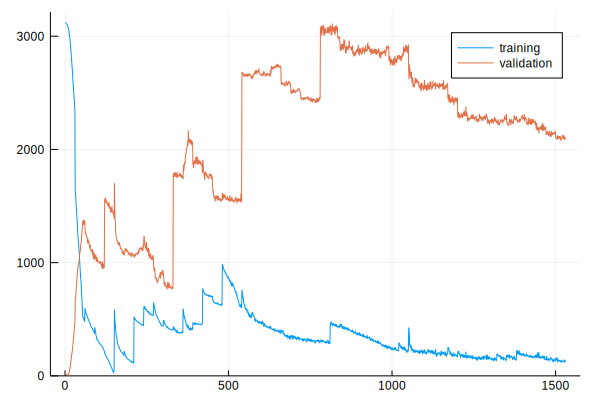

 53.490841 seconds (7.46 M allocations: 1.017 GiB, 0.95% gc time)


Progress:  51%|█████████████████████                    |  ETA: 3:31:06

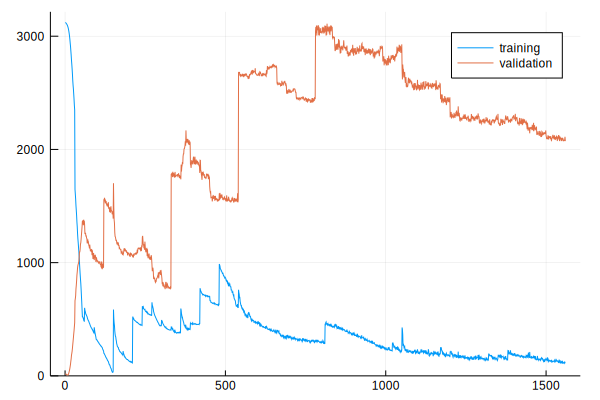

 26.298684 seconds (7.68 M allocations: 1.047 GiB, 1.61% gc time)


Progress:  52%|█████████████████████                    |  ETA: 3:27:33

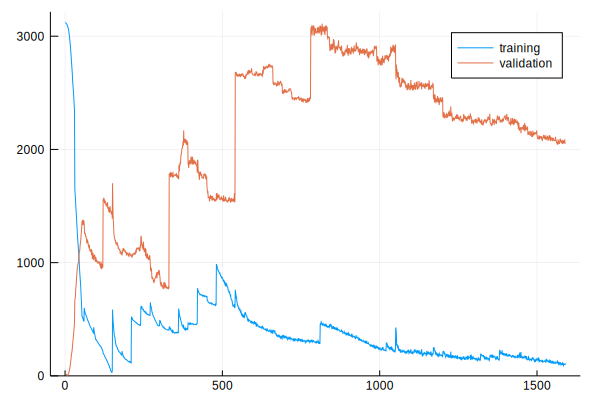

 26.992978 seconds (7.72 M allocations: 1.053 GiB, 1.62% gc time)


Progress:  53%|██████████████████████                   |  ETA: 3:22:19

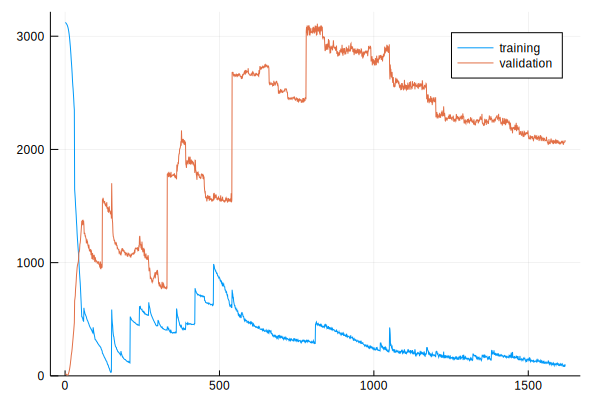

 27.541763 seconds (7.83 M allocations: 1.067 GiB, 1.52% gc time)


Progress:  54%|██████████████████████                   |  ETA: 3:16:40

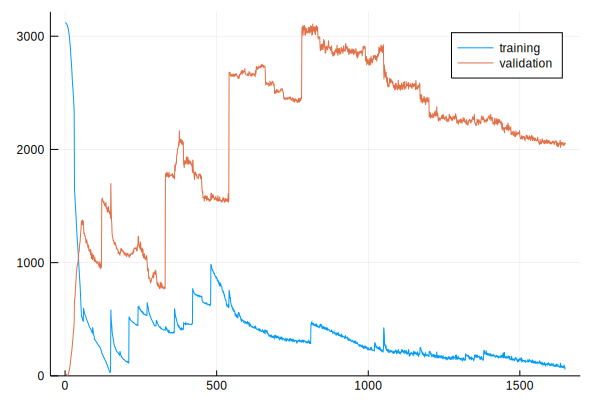

 25.902124 seconds (7.95 M allocations: 1.083 GiB, 2.11% gc time)


Progress:  55%|███████████████████████                  |  ETA: 3:11:24

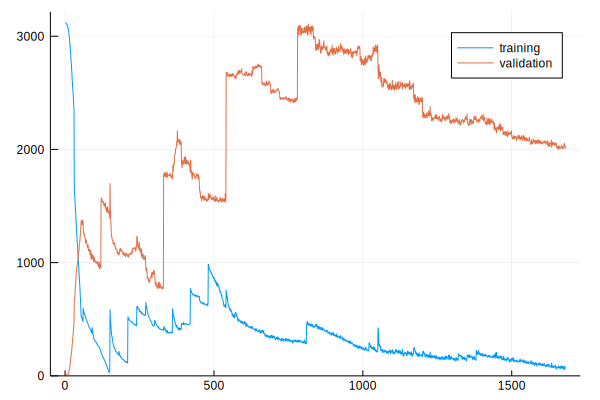

 36.431630 seconds (8.05 M allocations: 1.097 GiB, 1.54% gc time)


Progress:  56%|███████████████████████                  |  ETA: 3:06:23

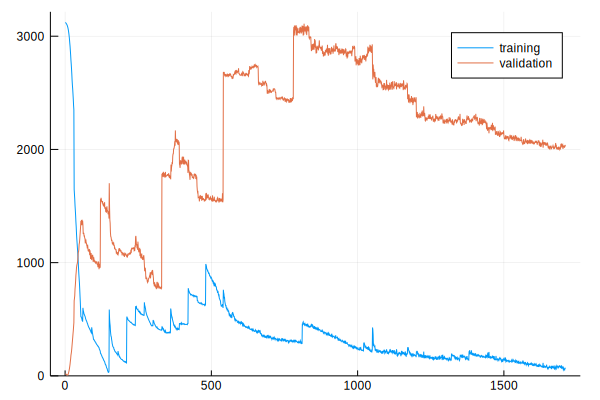

 33.308022 seconds (8.28 M allocations: 1.128 GiB, 1.50% gc time)


Progress:  57%|███████████████████████                  |  ETA: 3:02:57

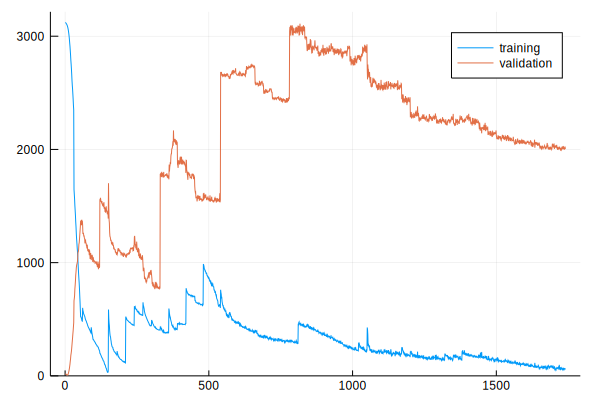

 32.482196 seconds (8.42 M allocations: 1.147 GiB, 1.37% gc time)


Progress:  58%|████████████████████████                 |  ETA: 2:59:42

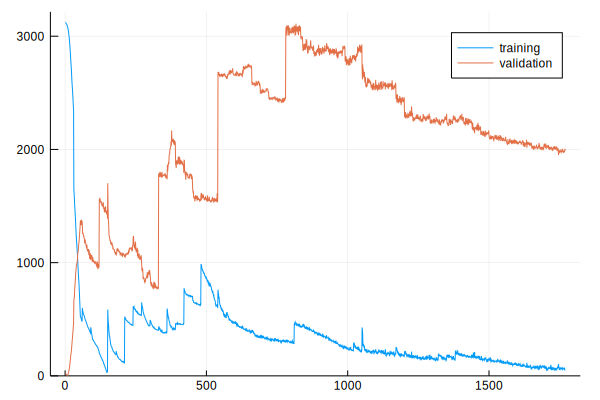

 31.406642 seconds (8.49 M allocations: 1.157 GiB, 1.43% gc time)


Progress:  59%|████████████████████████                 |  ETA: 2:54:39

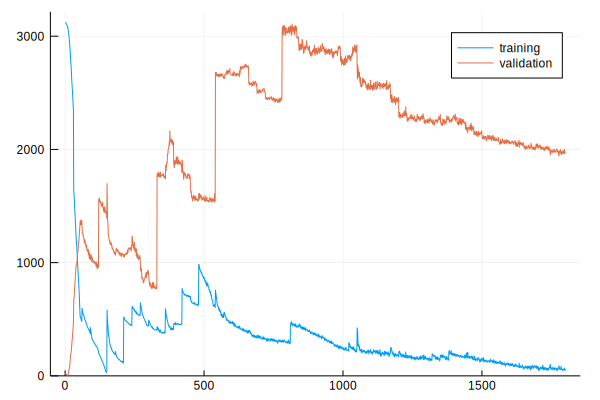

 32.212288 seconds (8.58 M allocations: 1.169 GiB, 2.31% gc time)


Progress:  60%|█████████████████████████                |  ETA: 2:48:56

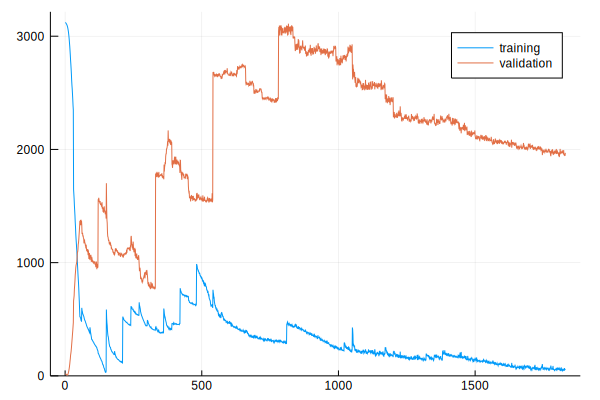

 31.638069 seconds (8.75 M allocations: 1.191 GiB, 1.63% gc time)


Progress:  61%|█████████████████████████                |  ETA: 2:44:27

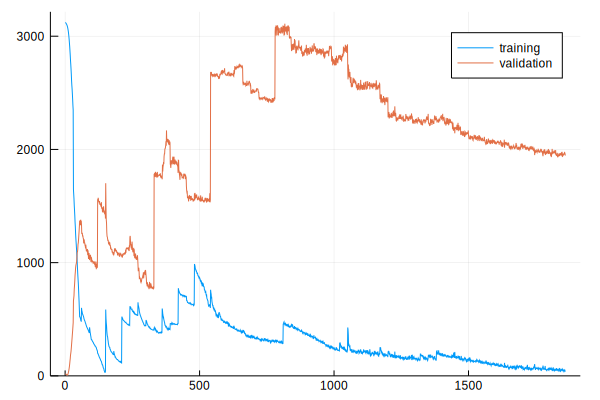

 28.919770 seconds (8.81 M allocations: 1.200 GiB, 1.78% gc time)


Progress:  62%|█████████████████████████                |  ETA: 2:39:05

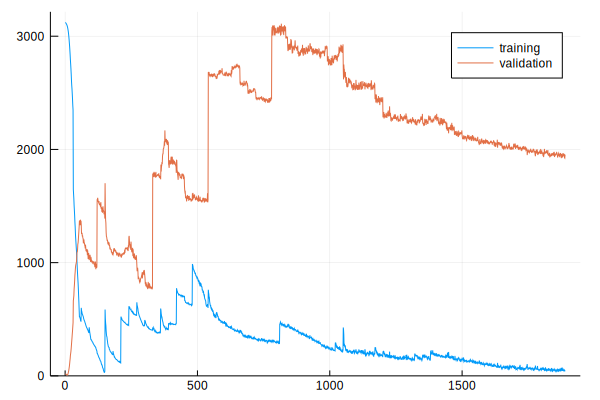

 36.764303 seconds (8.88 M allocations: 1.209 GiB, 1.32% gc time)


Progress:  63%|██████████████████████████               |  ETA: 2:34:03

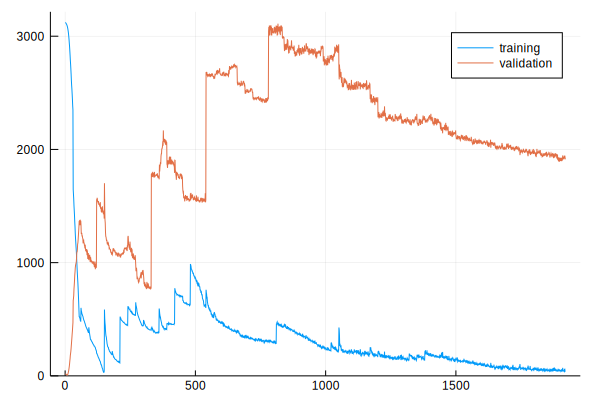

 35.724287 seconds (9.02 M allocations: 1.229 GiB, 1.55% gc time)


Progress:  64%|██████████████████████████               |  ETA: 2:30:54

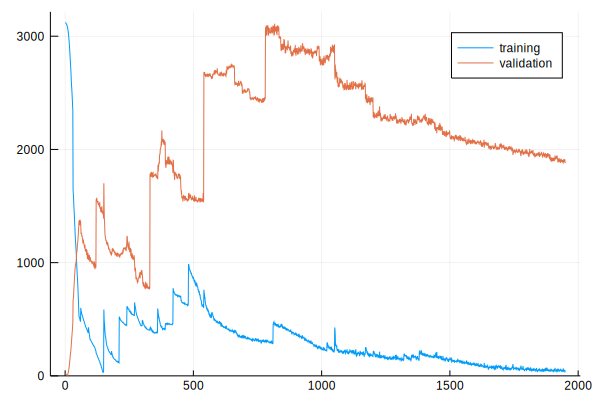

 33.454682 seconds (9.13 M allocations: 1.244 GiB, 1.64% gc time)


Progress:  65%|███████████████████████████              |  ETA: 2:26:28

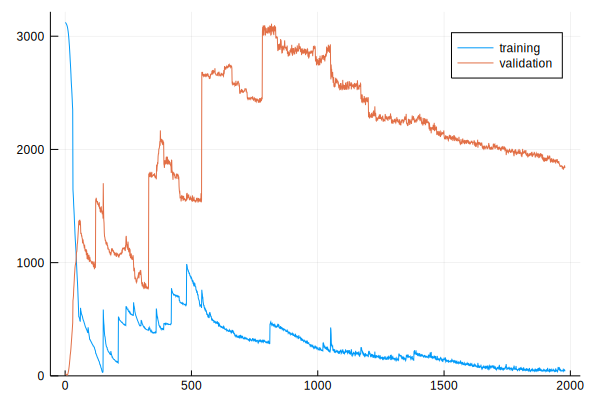

 35.908647 seconds (9.26 M allocations: 1.261 GiB, 1.57% gc time)


Progress:  66%|███████████████████████████              |  ETA: 2:22:06

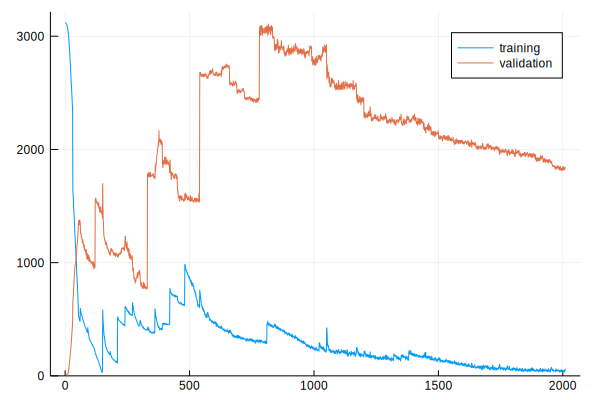

 41.628080 seconds (9.36 M allocations: 1.275 GiB, 1.21% gc time)


Progress:  67%|███████████████████████████              |  ETA: 2:17:18

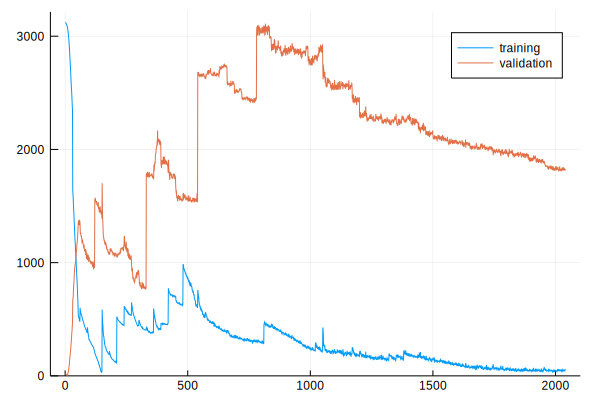

 31.129723 seconds (9.47 M allocations: 1.290 GiB, 1.68% gc time)


Progress:  68%|████████████████████████████             |  ETA: 2:12:36

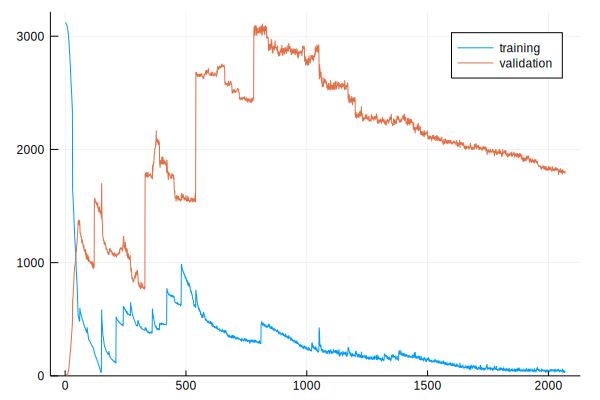

 27.011256 seconds (9.58 M allocations: 1.305 GiB, 2.04% gc time)


Progress:  69%|████████████████████████████             |  ETA: 2:08:05

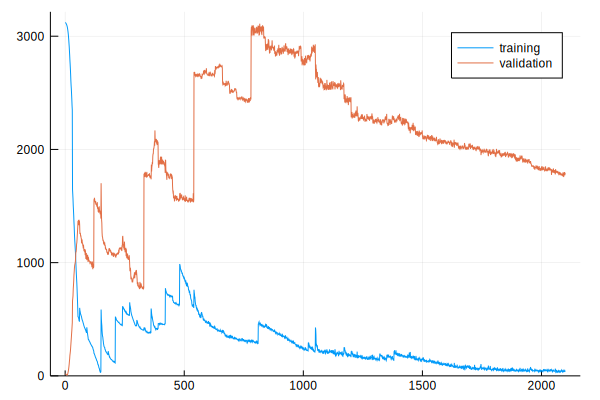

 35.398288 seconds (9.79 M allocations: 1.333 GiB, 1.69% gc time)


Progress:  70%|█████████████████████████████            |  ETA: 2:04:15

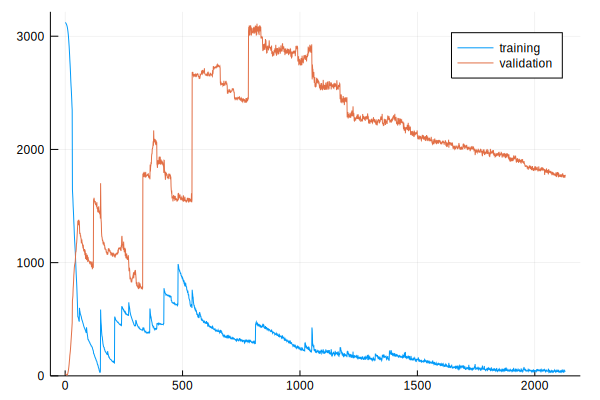

 34.400434 seconds (9.83 M allocations: 1.339 GiB, 1.89% gc time)


Progress:  71%|█████████████████████████████            |  ETA: 1:59:42

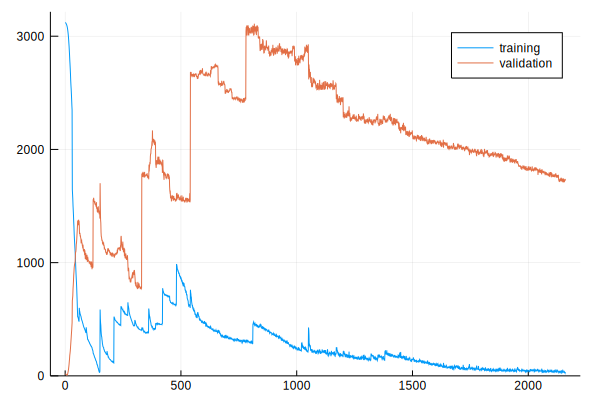

 33.148859 seconds (9.91 M allocations: 1.351 GiB, 1.81% gc time)


Progress:  72%|██████████████████████████████           |  ETA: 1:55:17

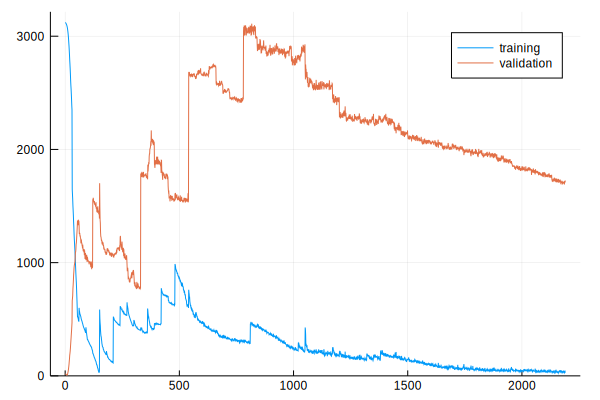

 33.160346 seconds (9.99 M allocations: 1.361 GiB, 1.78% gc time)


Progress:  73%|██████████████████████████████           |  ETA: 1:50:34

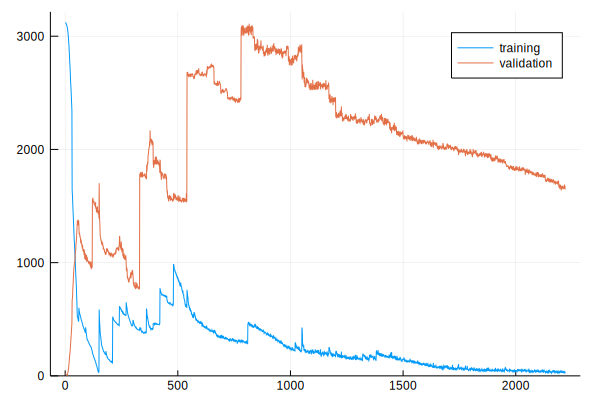

 38.725042 seconds (10.17 M allocations: 1.386 GiB, 1.45% gc time)


Progress:  74%|██████████████████████████████           |  ETA: 1:47:19

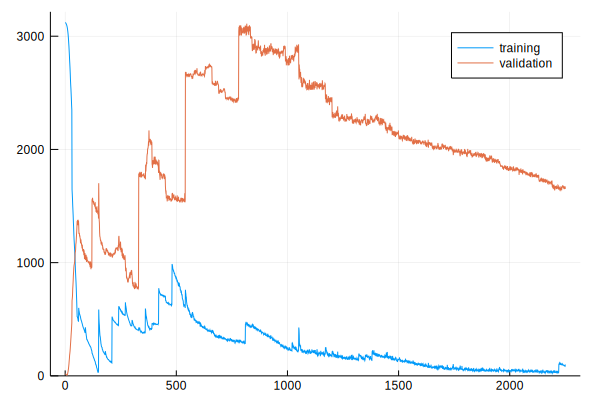

 45.315058 seconds (10.24 M allocations: 1.396 GiB, 1.30% gc time)


Progress:  75%|███████████████████████████████          |  ETA: 1:42:31

In [ ]:
datasets = Vector{LearningMPC.Dataset{Float64}}()
all_training_data = Vector{Tuple{Vector{Float64}, Float64, Float64}}()
all_validation_data = Vector{Tuple{Vector{Float64}, Float64, Float64}}()
losses = Vector{Tuple{Float64, Float64}}()

N_iter = 100
σv = 3.0

@showprogress for i in 1:N_iter
    dataset = LearningMPC.Dataset(lqrsol)
    for i in 1:2
        collect_into!(dataset.training_data)
    end
    collect_into!(dataset.testing_data, i / N_iter * σv)
    collect_into!(dataset.validation_data, i / N_iter * σv)
    append!(all_training_data, features.(dataset.training_data))
    append!(all_validation_data, features.(dataset.validation_data))
    filter!(all_training_data) do sample
        all(isfinite, sample[1]) && isfinite(sample[2]) && isfinite(sample[3])
    end
    filter!(all_validation_data) do sample
        all(isfinite, sample[1]) && isfinite(sample[2]) && isfinite(sample[3])
    end
    
    @time for i in 1:30
        Flux.train!(loss, shuffleobs(all_training_data), optimizer)
        push!(losses, 
            (mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_training_data),
             mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_validation_data)))
    end
    push!(datasets, dataset)
    
    jldopen("boxatlas.jld2", "w") do file
        file["datasets"] = datasets
        file["net"] = net
        file["lqrsol"] = lqrsol
        file["mpc_params"] = Dict(
            "Δt" => params.Δt,
            "horizon" => params.horizon,
        )
        file["all_training_data"] = all_training_data
        file["all_validation_data"] = all_validation_data
        file["losses"] = losses
    end
    
    plt = plot(first.(losses), label="training")
    plot!(plt, last.(losses), label="validation")
    ylims!(plt, (0, ylims(plt)[2]))
    display(plt)
end

In [ ]:
x0 = nominal_state(robot)
set_velocity!(x0, findjoint(robot.mechanism, "floating_base"), [-2, 0, 0])
results = LCPSim.simulate(x0, net_mpc_controller, environment(robot), 0.01, 300, params.lcp_solver);

In [ ]:
set_configuration!(mvis, configuration(results[1].state))

In [ ]:
playback(mvis, results, 0.02)